## Changelog

2023-04-17, 12:07

*   Extended range of values for tuning `C` parameter for LogisticRegression.
*   Fixed bug where saved confusion matrix figures would be empty.

2023-04-16, 16:28

*   Fixed bug with data leaking between training and test set due to not setting seed for numpy prior to undersampling in data preprocessing.

2023-04-15, 19:43

*   Added Gathering Results section.
*   Modified `test_models()` to handle single model input differently
*   Added `prepare_results()` to Gathering Results section for collecting all testing results, saving them to .csv and saving plots (only confusion matrices, currently).

2023-04-15, 15:02

*   Modified `train_models()` to integrate XGBoost.
*   Added model and model parameters for XGBoost.
*   Modified tuning parameter values for Random Forest and SVM.
*   Modified tuning parameter values for Logistic Regression to include both Ridge (L2) and LASSO (L1) penalties - with 'liblinear' solver as it is the only solver that works with both L1 and L2 penalties.
*   Added short set of instructions for notebook use under Setup section.

2023-04-12, 18:00

*   Added model saving and loading functionality (including model training results and metrics).
*   Removed non-SMOTE subsampling strategies from train_models().



## Google Colab Setup (COMMENT OUT IF NOT NEEDED)

In [ ]:
# !cp -r drive/MyDrive/STAT841/Data/baf_data/ .
# !cp -r drive/MyDrive/STAT841/Code/saved/ .
# !mkdir results
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#!cp -r saved/ drive/MyDrive/STAT841/Code/

# STAT 841: Final Project

## Setup

### Instructions

*   Make sure to set `loading_models` to correctly set to True or False, as desired.
*   If training models (not loading), make sure that relevant models and model parameters are included (uncommented) in the relevant code block under Training Pipeline section.
*   If training models, verify that correct CV scorer is selected, and that the `file_prefix` string and the `strategy` parameter for `train_models()` are appropriately set.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
## Set whether or not to load models or train from scratch
loading_models = True

## Load and view data

In [ ]:
# data = pd.read_csv('baf_data/Base.csv')
PATH = '/content/gdrive/MyDrive/STAT841/'
data = pd.read_csv(PATH + 'Data/baf_data/Base.csv')
n = len(data)
print(f'Number of entries: {n}.')
data.head()

Number of entries: 1000000.


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [ ]:
## Drop 'month' column as it is not a valid feature.
data = data.drop(columns=['month'])
data.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,24,0,500.0,0,INTERNET,3.888115,windows,0,1,0
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,15,0,1500.0,0,INTERNET,31.798819,windows,0,1,0
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,-1,0,200.0,0,INTERNET,4.728705,other,0,1,0
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,31,1,200.0,0,INTERNET,2.047904,linux,0,1,0
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,31,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0


In [ ]:
print('Number of missing values: ', data.isnull().sum().sum())

Number of missing values:  0


Class 0 (no fraud)
Count:  11029
Percentage of dataset:  1.1 %

Class 1 (fraud)
Count:  988971
Percentage of dataset:  98.9 %


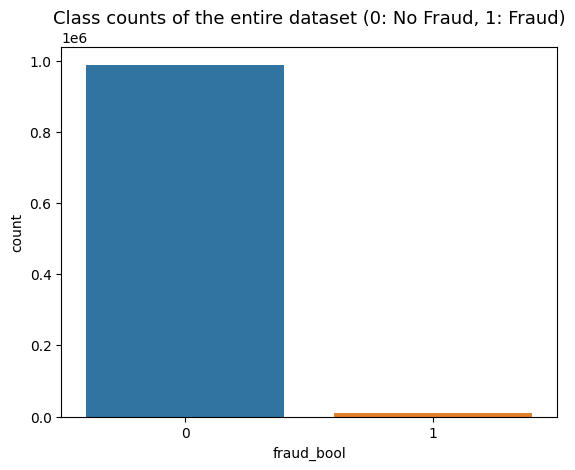

In [ ]:
sns.countplot(x='fraud_bool', data=data)
plt.title('Class counts of the entire dataset (0: No Fraud, 1: Fraud)', fontsize=13)

count_fraud, count_legit = data['fraud_bool'].value_counts()[1], data['fraud_bool'].value_counts()[0]
pctg_fraud, pctg_legit = round(count_fraud/n, 4), round(count_legit/n, 4)

print('Class 0 (no fraud)\nCount: ', count_fraud)
print('Percentage of dataset: ', round(pctg_fraud * 100,2), '%')

print('\nClass 1 (fraud)\nCount: ', count_legit)
print('Percentage of dataset: ', round(pctg_legit * 100,2), '%')

## Create a sample from the whole dataset

This dataset is huge and largely imbalanced. We have drawn a smaller sample without replacement for the classifiers to run on. We have assigned weights to each entry according to its label's rareness, such that "fraud" as the rarer class has a larger probability to be included. The resulted sample is more balanced.

Class 0 (no fraud)
Count:  11029
Percentage of sample:  1.1 %

Class 1 (fraud)
Count:  88971
Percentage of sample:  8.9 %


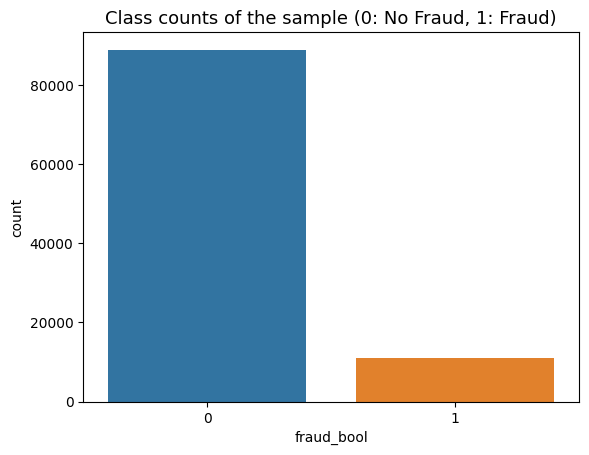

In [ ]:
# Set seed for reproducibility
np.random.seed(841)

# A vector of the probability of each sample being drawn
probabilities = [pctg_legit/count_fraud if label == 1 else pctg_fraud/count_legit for label in data["fraud_bool"]]
sample = data.loc[np.random.choice(data.index, size=100000, replace= False, p=probabilities)]

# plot the resulting sample's distribution
sns.countplot(x='fraud_bool', data=sample)
plt.title('Class counts of the sample (0: No Fraud, 1: Fraud)', fontsize=13)

count_fraud_sample = sample['fraud_bool'].value_counts()[1]
count_legit_sample = sample['fraud_bool'].value_counts()[0]
pctg_fraud_sample = round(count_fraud_sample/n, 4) 
pctg_legit_sample = round(count_legit_sample/n, 4)

print('Class 0 (no fraud)\nCount: ', count_fraud_sample)
print('Percentage of sample: ', round(pctg_fraud_sample * 100,2), '%')

print('\nClass 1 (fraud)\nCount: ', count_legit_sample)
print('Percentage of sample: ', round(pctg_legit_sample * 100,2), '%')

## Data preprocessing

In [ ]:
###### View all categorical columns
cat_cols = [col for col in sample.columns if sample[col].dtype == 'O']
cat_cols

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

In [ ]:
###### One-hot encode all categorical columns
def one_hot_data(orig_data, features_to_encode):
    res = orig_data
    for f in features_to_encode:
        dummies = pd.get_dummies(orig_data[[f]])
        res = pd.concat([res, dummies], axis=1)
        res = res.drop([f], axis=1)
    return res

sample_1hot = one_hot_data(sample, cat_cols)
sample_1hot.shape # dimension after one-hot transformation

(100000, 52)

In [ ]:
###### Train-test split (non-neural network models)
from sklearn.model_selection import StratifiedShuffleSplit

k_fold = 5

sss = StratifiedShuffleSplit(n_splits= k_fold, test_size= 0.15, random_state=0)
X = sample_1hot[sample_1hot.columns.drop("fraud_bool")]
y = sample_1hot["fraud_bool"]

for train_index, test_index in sss.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Training Pipeline (non-neural network models)

In [ ]:
import time

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.utils import class_weight

from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, matthews_corrcoef, make_scorer, classification_report


In [ ]:
def convert_duration(duration):
  hours, rem = divmod(duration, 3600)
  minutes, seconds = divmod(rem, 60)
  return int(hours), int(minutes), int(seconds)  

def train_models(models, model_params, X_train, y_train, scaler, scorer, strategy='None'):

  trained_models = {}
  trained_model_params = {}
  training_times = {}
  cv_scores = {}

  skfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

  for model_name in models:
    model_class = models[model_name].__class__
    print(model_class.__name__)
    print('\nCross-validation with strategy: {}, for {}'.format(strategy, model_class.__name__))

    tuning_params = model_params[model_name].copy()

    ## Setup pipeline based on imbalanced learning strategy
    if strategy == 'SMOTE':
      print('Oversampling with SMOTE')
      pipeline = Pipeline([('scaler',scaler), ('sampl',SMOTE(sampling_strategy='minority')), ('cf', model_class())]) 
    elif strategy == 'Cost':
      print('Cost-sensitive')
      if model_name == 'XGBoost':
        # XGBClassifier has scale_pos_weight parameter instead of class_weight.
        # For equivalent balanced weighting, we take weight as (Sum of No Fraud / Sum of Fraud)
        xgb_weight = np.count_nonzero(y_train == 0) / np.count_nonzero(y_train == 1)
        tuning_params['cf__scale_pos_weight'] = [xgb_weight]
        pipeline = Pipeline([('scaler',scaler), ('cf', model_class())])
      else:
        #tuning_params['cf__class_weight'] = ['balanced']
        pipeline = Pipeline([('scaler',scaler), ('cf', model_class(class_weight='balanced'))]) 
    elif strategy == 'None':
      print('No subsampling')
      pipeline = Pipeline([('scaler',scaler), ('cf', model_class())]) 
    else:
      print('Invalid strategy')
      return

    ## Grid Search CV
    grid_search_cv = GridSearchCV(pipeline, model_params[model_name], \
                                  n_jobs = 3, scoring=scorer, \
                                  cv = skfold, return_train_score=True, verbose=1)
    
    ## Start training
    start_time = time.time()

    grid_search_cv.fit(X_train, y_train)
    cv_score = cross_val_score(grid_search_cv, X_train, y_train, scoring=scorer, cv=skfold)

    train_time = time.time() - start_time
    hours, minutes, seconds = convert_duration(train_time)
    print('Training took {} hour(s) {} minute(s) {} second(s)\n'.format(int(hours), int(minutes), int(seconds)))

    ## Add model and results to output
    trained_models[model_name] = grid_search_cv.best_estimator_
    trained_model_params[model_name] = grid_search_cv.best_params_
    training_times[model_name] = train_time
    cv_scores[model_name] = cv_score

    print(model_class.__name__)
    print('')
    print("Parameters: {}".format(grid_search_cv.best_params_))
    print("Score: {}".format(grid_search_cv.best_score_))
    print('---' * 45)

  return trained_models, trained_model_params, training_times, cv_scores

In [ ]:
###### Models, tuning parameters, and scorer

models = {
    'LogReg': LogisticRegression(),
    # 'SVC': SVC(),
    # 'RF': RandomForestClassifier(), # RandomForest does not have a straightforward way of determining what values of alpha to consider - do pre-pruning instead
    # 'XGBoost': XGBClassifier()
}

model_params = {
    'LogReg': {'cf__penalty': ['l1', 'l2'], 'cf__solver': ['liblinear'], 'cf__C': [(10 ** n) for n in range(-4,4)]},
    # 'SVC': {'cf__C': [(10 ** n) for n in range(-1,2)], 'cf__kernel': ['rbf', 'poly', 'linear']},
    # 'RF': {'cf__max_depth': [5, 10, 15, 20], 'cf__n_estimators': [10, 20, 50, 100], 'cf__min_samples_split': [2, 5, 10, 20, 50], 'cf__min_samples_leaf': [1, 3, 5, 10, 20, 50]},
    # 'RF': {'cf__n_estimators': [50, 75, 100], 
    #        'cf__max_depth': [None if n < 0 else n for n in range(-5,20,6)]}, 
          #  'cf__min_samples_leaf': [1 if n==0 else (n/200) for n in range(0,4)]}, 
    # 'XGBoost': {'cf__tree_method': ["gpu_hist"], # With GPU
    #             'cf__eta': [0.01, 0.1, 0.2],  
    #             'cf__max_depth': list(range(3,10,3)), 
    #             'cf__min_child_weight': list(range(1,6,2)), 
    #             'cf__gamma': [n/10.0 for n in range(0,3)]}
}

std_scaler = StandardScaler()
mcc_scorer = make_scorer(matthews_corrcoef)
#f1_scorer = make_scorer(f1_score)

In [ ]:
###### Train and save model, or load pre-trained model
import pickle

file_prefix = 'cost_logreg_'

if loading_models:
  trained_models = pickle.load(open('saved/{}trained_models.sav'.format(file_prefix), 'rb'))
  params = pickle.load(open('saved/{}params.sav'.format(file_prefix), 'rb'))
  training_times = pickle.load(open('saved/{}training_times.sav'.format(file_prefix), 'rb'))
  scores = pickle.load(open('saved/{}scores.sav'.format(file_prefix), 'rb'))
else:
  trained_models, params, training_times, scores = train_models(models, 
                                                                model_params, 
                                                                X_train, 
                                                                y_train, 
                                                                scaler=std_scaler, 
                                                                scorer=mcc_scorer, 
                                                                strategy='Cost')
  
  pickle.dump(trained_models, open('saved/{}trained_models.sav'.format(file_prefix), 'wb'))
  pickle.dump(params, open('saved/{}params.sav'.format(file_prefix), 'wb'))
  pickle.dump(training_times, open('saved/{}training_times.sav'.format(file_prefix), 'wb'))
  pickle.dump(scores, open('saved/{}scores.sav'.format(file_prefix), 'wb'))

In [ ]:
# For overnight running
#!cp -r saved/ drive/MyDrive/STAT841/Code/

## Testing (non-neural network models)

In [ ]:
import os

def print_results(metrics, index):
  print("accuracy: {}".format(metrics['accuracy'][index]))
  print("precision: {}".format(metrics['precision'][index]))
  print("recall: {}".format(metrics['recall'][index]))
  print("f1: {}".format(metrics['f1_score'][index]))
  print('ROC AUC: {}'.format(metrics['roc_score'][index]))
  print('MCC: {}'.format(metrics['mcc_score'][index]))


def test_models(trained_models, X_test, y_test, strategy=None, save_folder_path=None):
  labels = ['No Fraud', 'Fraud']
  all_results = {'strategy': [],
                 'model': [], 
                 'accuracy': [], 
                 'precision': [], 
                 'recall': [],
                 'f1_score': [],
                 'mcc_score': [],
                 'roc_score': [],
                 }

  fig, ax = plt.subplots(len(trained_models), 1, figsize=(4,len(trained_models)*3), squeeze=False) # For confusion matrices
  fig.tight_layout(pad=5.0)
  index = 0

  for model_name, model in trained_models.items():

    model_class = model.named_steps['cf'].__class__.__name__
    print('Test results for model: ', model_class)
    print('')

    model_prediction = model.predict(X_test)

    print(classification_report(y_test, model_prediction, target_names=labels))

    if strategy:
      all_results['strategy'].append(strategy)
    else:
      all_results['strategy'].append('NA')
    
    all_results['model'].append(model_class)
    all_results['accuracy'].append(model.score(X_test, y_test))
    all_results['precision'].append(precision_score(y_test, model_prediction))
    all_results['recall'].append(recall_score(y_test, model_prediction))
    all_results['f1_score'].append(f1_score(y_test, model_prediction))
    all_results['mcc_score'].append(matthews_corrcoef(y_test, model_prediction))
    all_results['roc_score'].append(roc_auc_score(y_test, model_prediction))

    print_results(all_results, index)

    if len(trained_models) > 1:
      print('---' * 45)

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, model_prediction)
    sns.heatmap(conf_mat, ax=ax[index][0], annot=True, cmap=plt.cm.Reds, fmt='d')
    if strategy:
      ax[index, 0].set_title("{} {}".format(strategy, model_class), fontsize=11)
    else:
      ax[index, 0].set_title("{}".format(model_class), fontsize=11)
    ax[index, 0].set_xticklabels(labels, fontsize=8, rotation=0)
    ax[index, 0].set_yticklabels(labels, fontsize=8, rotation=360)
    ax[index, 0].set_ylabel('Actual Class')
    ax[index, 0].set_xlabel('Predicted Class')

    index += 1

  print('')
  plt.show()

  if save_folder_path:
    filename = ''
    if strategy:
      filename = strategy.lower() + '_'
    
    if len(trained_models) == 1:
      filename = filename + list(trained_models.keys())[0].lower() + '_'

    filename = filename + 'conf_matrix.png'

    fig.savefig(os.path.join(save_folder_path, filename), bbox_inches='tight')

  return all_results



Test results for model:  LogisticRegression

              precision    recall  f1-score   support

    No Fraud       0.97      0.81      0.88     13346
       Fraud       0.33      0.79      0.47      1654

    accuracy                           0.80     15000
   macro avg       0.65      0.80      0.68     15000
weighted avg       0.90      0.80      0.83     15000

accuracy: 0.8037333333333333
precision: 0.3348694316436252
recall: 0.7908101571946796
f1: 0.4705035971223022
ROC AUC: 0.7980725445047278
MCC: 0.42548581230443133



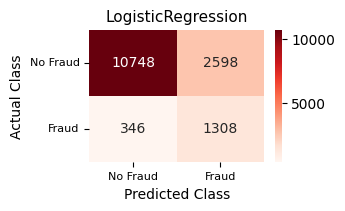

In [ ]:
results = test_models(trained_models, X_test, y_test)

In [ ]:
results

{'strategy': ['NA'],
 'model': ['LogisticRegression'],
 'accuracy': [0.8037333333333333],
 'precision': [0.3348694316436252],
 'recall': [0.7908101571946796],
 'f1_score': [0.4705035971223022],
 'mcc_score': [0.42548581230443133],
 'roc_score': [0.7980725445047278]}

In [ ]:
#params

In [ ]:
#trained_models['RF'].named_steps['cf'].get_params()

## Gathering Results (non-neural network models)

In [ ]:
## Assumes one model per pickled file
def prepare_results(save_folder_path, result_folder_path, strategies, model_names, X_test, y_test):
  all_results = list()

  for strategy in strategies:
    print("\nProcessing models trained with \'{}\' strategy.".format(strategy))

    for model_name in model_names:
      print("\n{}:\n".format(model_name))
      model = pickle.load(open('{}/{}_{}_trained_models.sav'.format(save_folder_path, strategy.lower(), model_name.lower()), 'rb'))
      params = pickle.load(open('{}/{}_{}_params.sav'.format(save_folder_path, strategy.lower(), model_name.lower()), 'rb'))
      training_times = pickle.load(open('{}/{}_{}_training_times.sav'.format(save_folder_path, strategy.lower(), model_name.lower()), 'rb'))
      scores = pickle.load(open('{}/{}_{}_scores.sav'.format(save_folder_path, strategy.lower(), model_name.lower()), 'rb'))
      
      ## Get test results
      model_results = test_models(model, X_test, y_test, strategy, result_folder_path)

      for key, val in model_results.items():
        # Extract values from list
        model_results[key] = val[0]

      ## Add training_times, params and scores
      model_results['training_time'] = training_times[model_name]
      model_results['model_params'] = params[model_name]
      model_results['cv_scores'] = scores[model_name]
      print(scores[model_name])

      all_results.append(model_results)

    print('\n' + '---' * 45)
  
  all_results = pd.DataFrame.from_records(all_results) 
  all_results.to_csv(os.path.join(result_folder_path, 'all_results.csv')) 

  return all_results


Processing models trained with 'Base' strategy.

LogReg:

Test results for model:  LogisticRegression

              precision    recall  f1-score   support

    No Fraud       0.92      0.98      0.95     13346
       Fraud       0.65      0.32      0.43      1654

    accuracy                           0.91     15000
   macro avg       0.79      0.65      0.69     15000
weighted avg       0.89      0.91      0.89     15000

accuracy: 0.9062666666666667
precision: 0.6519607843137255
recall: 0.3216444981862152
f1: 0.43076923076923074
ROC AUC: 0.650182356990605
MCC: 0.4148086305658591



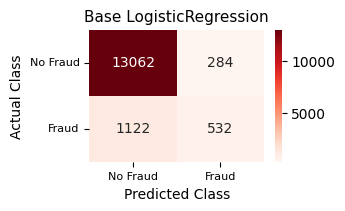

[0.41832253 0.42707889 0.44205627 0.42984699 0.42915262]

RF:

Test results for model:  RandomForestClassifier

              precision    recall  f1-score   support

    No Fraud       0.92      0.99      0.95     13346
       Fraud       0.72      0.27      0.39      1654

    accuracy                           0.91     15000
   macro avg       0.82      0.63      0.67     15000
weighted avg       0.89      0.91      0.89     15000

accuracy: 0.9078
precision: 0.7203252032520325
recall: 0.2678355501813785
f1: 0.39048038783605116
ROC AUC: 0.6274738967750891
MCC: 0.40271896270047947



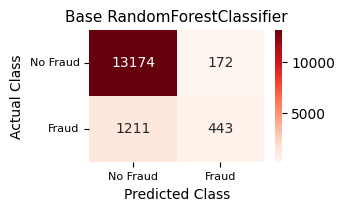

[0.39232531 0.40321367 0.41429885 0.40968577 0.38207211]

XGBoost:

[16:09:23] WARNING: ../src/gbm/gbtree.cc:415: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
[16:09:23] WARNING: ../src/gbm/gbtree.cc:425: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
[16:09:23] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
Test results for model:  XGBClassifier

              precision    recall  f1-score   support

    No Fraud       0.93      0.98      0.95     13346
       Fraud       0.70      0.37      0.49      1654

    accuracy                           0.91     15000
   macro avg       0.81      0.68      0.72     15000
weighted avg       0.90      0.91   

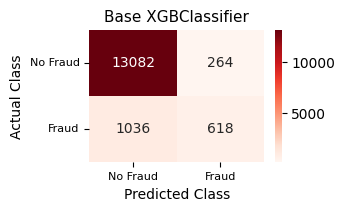

[0.47364072 0.46298461 0.4848551  0.47490325 0.46448186]

---------------------------------------------------------------------------------------------------------------------------------------

Processing models trained with 'SMOTE' strategy.

LogReg:

Test results for model:  LogisticRegression

              precision    recall  f1-score   support

    No Fraud       0.97      0.82      0.89     13346
       Fraud       0.34      0.77      0.48      1654

    accuracy                           0.81     15000
   macro avg       0.65      0.80      0.68     15000
weighted avg       0.90      0.81      0.84     15000

accuracy: 0.8116666666666666
precision: 0.3430715625837577
recall: 0.7738814993954051
f1: 0.47539461467038074
ROC AUC: 0.7951154837004
MCC: 0.42767118561133083



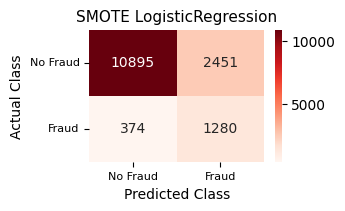

[0.42588286 0.43416801 0.4204781  0.42750929 0.42741532]

RF:

Test results for model:  RandomForestClassifier

              precision    recall  f1-score   support

    No Fraud       0.95      0.91      0.93     13346
       Fraud       0.46      0.60      0.52      1654

    accuracy                           0.88     15000
   macro avg       0.71      0.76      0.73     15000
weighted avg       0.90      0.88      0.89     15000

accuracy: 0.8797333333333334
precision: 0.4649859943977591
recall: 0.6021765417170496
f1: 0.5247629083245521
ROC AUC: 0.758154058360398
MCC: 0.4622275440256973



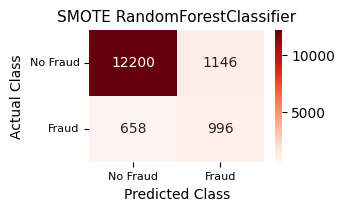

[0.47215543 0.45937085 0.45842488 0.44852038 0.46362896]

XGBoost:

[16:09:27] WARNING: ../src/gbm/gbtree.cc:415: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
[16:09:27] WARNING: ../src/gbm/gbtree.cc:425: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
[16:09:27] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
Test results for model:  XGBClassifier

              precision    recall  f1-score   support

    No Fraud       0.94      0.96      0.95     13346
       Fraud       0.58      0.49      0.53      1654

    accuracy                           0.91     15000
   macro avg       0.76      0.72      0.74     15000
weighted avg       0.90      0.91   

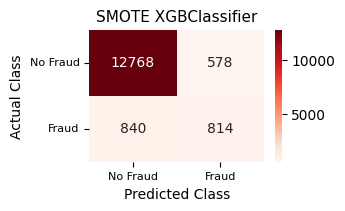

[0.48480965 0.50460123 0.47827477 0.48149215 0.49709507]

---------------------------------------------------------------------------------------------------------------------------------------

Processing models trained with 'Cost' strategy.

LogReg:

Test results for model:  LogisticRegression

              precision    recall  f1-score   support

    No Fraud       0.97      0.81      0.88     13346
       Fraud       0.33      0.79      0.47      1654

    accuracy                           0.80     15000
   macro avg       0.65      0.80      0.68     15000
weighted avg       0.90      0.80      0.83     15000

accuracy: 0.8037333333333333
precision: 0.3348694316436252
recall: 0.7908101571946796
f1: 0.4705035971223022
ROC AUC: 0.7980725445047278
MCC: 0.42548581230443133



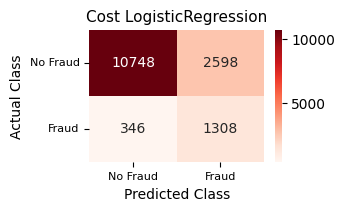

[0.42165791 0.42112043 0.42433957 0.42832447 0.41835894]

RF:

Test results for model:  RandomForestClassifier

              precision    recall  f1-score   support

    No Fraud       0.95      0.91      0.93     13346
       Fraud       0.46      0.62      0.52      1654

    accuracy                           0.88     15000
   macro avg       0.70      0.76      0.73     15000
weighted avg       0.90      0.88      0.88     15000

accuracy: 0.8768666666666667
precision: 0.45674585387718514
recall: 0.6160822249093107
f1: 0.5245817245817246
ROC AUC: 0.762634248974961
MCC: 0.4623772309497245



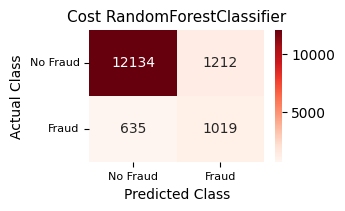

[0.45641208 0.47465903 0.46296407 0.45225948 0.46541343]

XGBoost:

[16:09:32] WARNING: ../src/gbm/gbtree.cc:415: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
[16:09:32] WARNING: ../src/gbm/gbtree.cc:425: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
[16:09:32] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
Test results for model:  XGBClassifier

              precision    recall  f1-score   support

    No Fraud       0.93      0.98      0.95     13346
       Fraud       0.70      0.37      0.49      1654

    accuracy                           0.91     15000
   macro avg       0.81      0.68      0.72     15000
weighted avg       0.90      0.91   

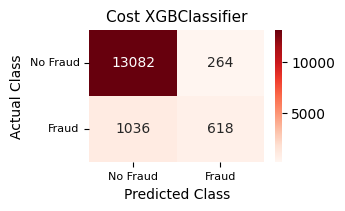

[0.47364072 0.46298461 0.4848551  0.47490325 0.46448186]

---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
##### Get all results

save_folder_rel_path = 'saved'
results_folder_rel_path = 'results'
strategies = ['Base', 'SMOTE', 'Cost']
model_names = ['LogReg', 'RF', 'XGBoost']

results = prepare_results(save_folder_rel_path, 
                          results_folder_rel_path, 
                          strategies, 
                          model_names, 
                          X_test, 
                          y_test)

In [ ]:
results

,strategy,model,accuracy,precision,recall,f1_score,mcc_score,roc_score,training_time,model_params,cv_scores
0,Base,LogisticRegression,0.906267,0.651961,0.321644,0.430769,0.414809,0.650182,1094.008490,"{'cf__C': 10, 'cf__penalty': 'l1', 'cf__solver...","[0.418322533093146, 0.42707889027584234, 0.442..."
1,Base,RandomForestClassifier,0.907800,0.720325,0.267836,0.390480,0.402719,0.627474,3600.330006,"{'cf__max_depth': None, 'cf__n_estimators': 75}","[0.3923253113687627, 0.4032136678953761, 0.414..."
2,Base,XGBClassifier,0.913333,0.700680,0.373640,0.487382,0.471142,0.676929,1984.737359,"{'cf__eta': 0.2, 'cf__gamma': 0.0, 'cf__max_de...","[0.4736407164849909, 0.46298461049479595, 0.48..."
3,SMOTE,LogisticRegression,0.811667,0.343072,0.773881,0.475395,0.427671,0.795115,974.110741,"{'cf__C': 0.1, 'cf__penalty': 'l1', 'cf__solve...","[0.4258828626777957, 0.4341680062063177, 0.420..."
4,SMOTE,RandomForestClassifier,0.879733,0.464986,0.602177,0.524763,0.462228,0.758154,5434.984471,"{'cf__max_depth': 13, 'cf__n_estimators': 75}","[0.47215542518609255, 0.4593708528088051, 0.45..."
5,SMOTE,XGBClassifier,0.905467,0.584770,0.492140,0.534471,0.484518,0.724416,3706.837207,"{'cf__eta': 0.2, 'cf__gamma': 0.2, 'cf__max_de...","[0.4848096511338287, 0.5046012328602169, 0.478..."
6,Cost,LogisticRegression,0.803733,0.334869,0.790810,0.470504,0.425486,0.798073,1625.598365,"{'cf__C': 1, 'cf__penalty': 'l1', 'cf__solver'...","[0.421657909560936, 0.42112042800147176, 0.424..."
7,Cost,RandomForestClassifier,0.876867,0.456746,0.616082,0.524582,0.462377,0.762634,2654.962461,"{'cf__max_depth': 13, 'cf__n_estimators': 100}","[0.4564120813703178, 0.4746590314105767, 0.462..."
8,Cost,XGBClassifier,0.913333,0.700680,0.373640,0.487382,0.471142,0.676929,2013.274483,"{'cf__eta': 0.2, 'cf__gamma': 0.0, 'cf__max_de...","[0.4736407164849909, 0.46298461049479595, 0.48..."


In [ ]:
# Saving to drive
# !cp -r results/ drive/MyDrive/STAT841/Code/

## Neural Network

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
# import os
# import time

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)

seed_everything(841)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Define classes and functions

In [ ]:
###### Define an MLP class with residual layer

class Res_MLP(nn.Module):
    def __init__(self, input_dim):
        super(Res_MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 27),
            nn.BatchNorm1d(27),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(27, 27),
            nn.BatchNorm1d(27),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(27, 27),
            nn.BatchNorm1d(27),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(27, 27),
            nn.BatchNorm1d(27),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.output = nn.Linear(27, 1)

    def forward(self, x):
        x = self.layer1(x)
        x1 = self.layer2(x)
        x1 = self.layer3(x1) + x # residual connection
        x1 = self.output(x1) 
        return torch.sigmoid(x1)

In [ ]:
def train_model_nn(X_train_np, y_train_np, X_val_np, y_val_np,
                   strategy= "Baseline", best_model_filename= "best_Baseline.pt"):
    # Convert the data to PyTorch tensors from numpy
    X_train_ts = torch.tensor(np.vstack(X_train_np).astype(np.float32))
    y_train_ts = torch.tensor(np.vstack(y_train_np).astype(np.float32))
    X_val_ts = torch.tensor(np.vstack(X_val_np).astype(np.float32))
    y_val_ts = torch.tensor(np.vstack(y_val_np).astype(np.float32))

    # Create DataLoader for mini-batch processing
    batch_size = 50
    train_nn = TensorDataset(X_train_ts, y_train_ts)
    val_nn = TensorDataset(X_val_ts, y_val_ts)
    train_loader= DataLoader(train_nn, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_nn, batch_size=batch_size, shuffle=False)

    input_dim = X_train_ts.shape[1]
    model = Res_MLP(input_dim)
    model.to(device)

    # Store errors for plotting
    train_losses = []
    val_losses = []
    val_mccs = []
    val_aucs = []

    # optimizer = optim.AdamW(model.parameters(), lr=0.1, weight_decay=0.0001)
    optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, 
                          nesterov=True, weight_decay=0.0001) # stochastic gradient descent,

    if strategy == "Baseline":
        # Weighted loss to deal with imbalance
        pos_weight = torch.Tensor([sum(y_train_np == 0) / sum(y_train_np == 1)]).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=150, T_mult=1)
        num_epochs = 300
        
    elif strategy == "SMOTE":
        criterion = nn.CrossEntropyLoss() # this case is balanced
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
        num_epochs = 500
    else:
        raise Exception("Unknown Strategy!")

    # best_val_loss = np.inf
    best_val_perform = -1 # best validation performance, measured by auc+mcc

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X.to(device)).squeeze()
            loss = criterion(outputs, batch_y.to(device).squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()
        train_loss /= len(train_nn)
        train_losses.append(train_loss)

        model.eval()
        val_outputs = []
        val_labels = []
        val_loss = 0.0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X.to(device)).squeeze()
                loss = criterion(outputs, batch_y.to(device).squeeze())
                val_loss += loss.item()
                val_outputs.extend(outputs.cpu().tolist())
                val_labels.extend(batch_y.cpu().tolist())

        val_loss /= len(val_nn)
        val_losses.append(val_loss)
        val_pred = [1 if x > 0.5 else 0 for x in val_outputs]
        val_mcc = matthews_corrcoef(val_labels, val_pred)
        val_auc = roc_auc_score(val_labels, val_outputs)
        val_mccs.append(val_mcc)
        val_aucs.append(val_auc)
        
        print(f"Epoch {epoch+1}/{num_epochs}:") 
        print(f"Epoch Train Loss: {train_loss}, Epoch Validation Loss: {val_loss}") 
        print(f"Epoch Validation MCC: {val_mcc}, Epoch Validation AUC: {val_auc}")

        if best_val_perform < val_mcc + val_auc:
            best_val_perform = val_mcc + val_auc
            torch.save(model.state_dict(), PATH + 'Code/results/' + best_model_filename)
            print("Model saved!")

    train_time = time.time() - start_time
    hours, minutes, seconds = convert_duration(train_time)
    print('Training took {} hour(s) {} minute(s) {} second(s)\n'.format(int(hours), 
                                                                        int(minutes), 
                                                                        int(seconds)))
    
    ###### Plot training and validation losses
    miny = min(min(val_losses), min(train_losses))
    maxy = max(max(val_losses), max(val_losses))
    plt.ylim([miny - 0.001, maxy + 0.001])
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"Train and Val Loss for NN - {strategy}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(PATH + 'Code/results/' + f'NN_Loss_{strategy}.png')
    plt.show()

    ###### Plot training and validation performance metrics
    plt.clf()
    plt.plot(val_mccs, label='Validation MCC scores', color="magenta")
    plt.plot(val_aucs, label='Validation AUC values', color='green')
    plt.title(f"Validation Performance for NN - {strategy}")
    plt.xlabel('Epochs')
    plt.ylabel('Score Value')
    plt.legend()
    plt.savefig(PATH + 'Code/results/' + f'NN_performance_{strategy}.png')
    plt.show()

    return train_time


In [ ]:
# Define result dictionary that will later be converted to dataframe
strategies, models = [], []
accuracies, precisions, recalls, f1_scores, mcc_scores, roc_scores = [], [], [], [], [], []
training_times, model_params, cv_scores = [], [], []

def test_model_nn(X_test_nn, y_test_nn, best_model_filename, strategy):
    batch_size = 50
    # load saved model
    best_model = Res_MLP(sample_1hot.shape[1] - 1).to(device)
    best_model.load_state_dict(torch.load(PATH + 'Code/results/' + best_model_filename))

    # Load test data
    X_test_nn = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_nn = torch.tensor(y_test_nn, dtype=torch.float32)
    test_nn = TensorDataset(X_test_nn, y_test_nn)
    test_nn = DataLoader(test_nn, batch_size=batch_size, shuffle=False)

    # Evaluate the model on the test set
    best_model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_nn:
            outputs = best_model(batch_X.to(device)).squeeze()
            test_outputs.extend(outputs.cpu().tolist())
            test_labels.extend(batch_y.tolist())

    test_pred = [1.0 if x > 0.5 else 0.0 for x in test_outputs]
    test_acc = round(1 - np.mean(np.int8(test_pred) != np.int8(test_labels)), 6)
    test_precision = precision_score(test_labels, test_pred)
    test_recall = recall_score(test_labels, test_pred)
    test_mcc = matthews_corrcoef(test_labels, test_pred)
    test_f1 = f1_score(test_labels, test_pred)
    test_auc = roc_auc_score(test_labels, test_outputs)
    conf_mat = confusion_matrix(test_labels, test_pred)

    strategies.append(strategy) 
    models.append('NeuralNetwork')
    accuracies.append(test_acc) 
    precisions.append(test_precision)
    recalls.append(test_recall)
    f1_scores.append(test_f1)
    mcc_scores.append(test_mcc)
    roc_scores.append(test_auc)
    model_params.append('Omitted'), 
    cv_scores.append('Not Applicable')

    print("Test results for Neural Networks on the {} sample")
    print(f"Test Accuracy: {test_acc}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test F1-score: {test_f1}")
    print(f"Test ROC AUC: {test_auc}")
    print(f"Test MCC: {test_mcc}")

    s = sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Reds, fmt='d')
    s.set(xlabel= "Predicted Class", ylabel= 'Actual Class', title="Neural Networks")
    plt.savefig(PATH + 'Code/results/' + f'{strategy}_nn_conf_matrix.png')

### Split and normalize data for two strategies

In [ ]:
X = sample_1hot.iloc[:, 1:].values
y = sample_1hot.iloc[:, 0].values

### Baseline

In [ ]:
# Split the dataset into stratified training, validation, and test sets

X_train_nn, X_temp_nn, y_train_nn, y_temp_nn = train_test_split(X, y, test_size=0.25, 
                                                                random_state=0, stratify=y)
X_val_nn, X_test_nn, y_val_nn, y_test_nn = train_test_split(X_temp_nn, y_temp_nn, test_size=0.5, 
                                                            random_state=0, stratify=y_temp_nn)

    
# Normalize data
scaler = StandardScaler().fit(X_train_nn)
X_train_norm = scaler.transform(X_train_nn)
X_val_norm = scaler.transform(X_val_nn)
X_test_norm = scaler.transform(X_test_nn)

X_train_norm.shape, X_val_norm.shape, X_test_norm.shape

((75000, 51), (12500, 51), (12500, 51))

Epoch 1/300:
Epoch Train Loss: 0.021796281389395395, Epoch Validation Loss: 0.02151975670814514
Epoch Validation MCC: 0.41976270355418255, Epoch Validation AUC: 0.866319389086715
Model saved!
Epoch 2/300:
Epoch Train Loss: 0.021464888881047566, Epoch Validation Loss: 0.02135482755661011
Epoch Validation MCC: 0.44359499604671315, Epoch Validation AUC: 0.871702491526559
Model saved!
Epoch 3/300:
Epoch Train Loss: 0.021396110641956328, Epoch Validation Loss: 0.021332352585792542
Epoch Validation MCC: 0.44613658685745733, Epoch Validation AUC: 0.8726428692386909
Model saved!
Epoch 4/300:
Epoch Train Loss: 0.02138430769364039, Epoch Validation Loss: 0.02135605593204498
Epoch Validation MCC: 0.4413162857349885, Epoch Validation AUC: 0.8744602764018632
Epoch 5/300:
Epoch Train Loss: 0.021367365470727286, Epoch Validation Loss: 0.02134729236125946
Epoch Validation MCC: 0.44433896037949705, Epoch Validation AUC: 0.8743948089246254
Epoch 6/300:
Epoch Train Loss: 0.02137872912009557, Epoch Valida

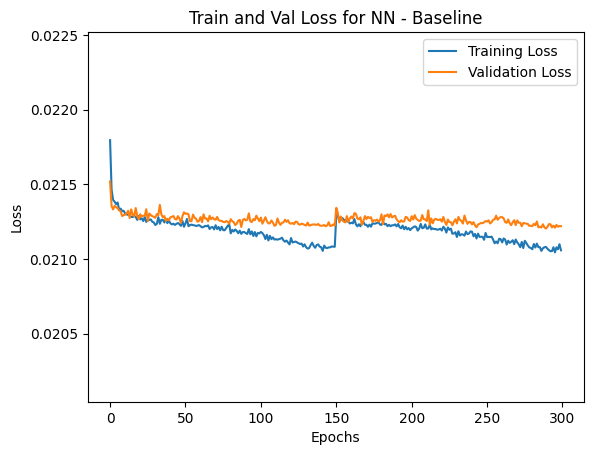

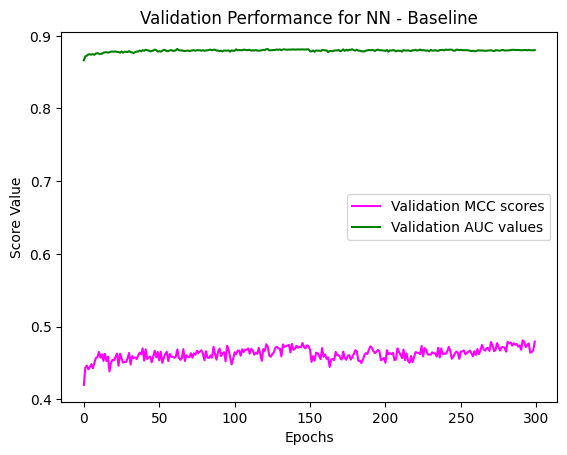

In [ ]:
###### Train
best_model_filename_base = "best_Baseline.pt"
training_time = train_model_nn(X_train_norm, y_train_nn, X_val_norm, y_val_nn,
                               strategy= "Baseline", best_model_filename= best_model_filename_base)
training_times.append(training_time)

In [ ]:
training_time

1207.7203857898712

Test results for Neural Networks on the {} sample
Test Accuracy: 0.86744
Test Precision: 0.4350860865518846
Test Recall: 0.6785195936139332
Test F1-score: 0.5301956336830167
Test ROC AUC: 0.8785271819683474
Test MCC: 0.47260536939101483


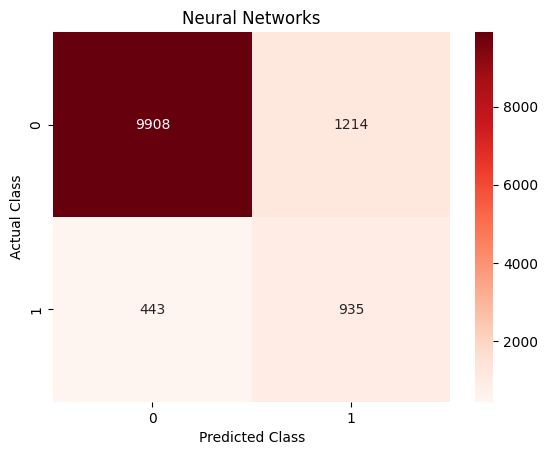

In [ ]:
test_model_nn(X_test_norm, y_test_nn, best_model_filename_base, "Baseline")

### SMOTE (Oversampling)

In [ ]:
from collections import Counter

In [ ]:
# Stack the previous train and val together for resampling
X_smt = np.vstack((X_train_norm, X_val_norm))
y_smt = np.concatenate((y_train_nn, y_val_nn))

oversample = SMOTE(sampling_strategy='minority')
X_smt, y_smt = oversample.fit_resample(X_smt, y_smt)
counter = Counter(y_smt)
print(counter) # view new sample distribution

Counter({0: 77849, 1: 77849})


In [ ]:
# Split the new sample into train and validation set

X_train_smt, X_val_smt, y_train_smt, y_val_smt = train_test_split(X_smt, y_smt, test_size=0.15, 
                                                                  random_state=0)
X_train_smt.shape, X_val_smt.shape

((132343, 51), (23355, 51))

Epoch 1/500:
Epoch Train Loss: 1.8515753834343232, Epoch Validation Loss: 1.8840022355579662
Epoch Validation MCC: 0.6471392974372088, Epoch Validation AUC: 0.8981412899656429
Model saved!
Epoch 2/500:
Epoch Train Loss: 1.847656217803232, Epoch Validation Loss: 1.8809425050200141
Epoch Validation MCC: 0.6596423701888083, Epoch Validation AUC: 0.9030165285958369
Model saved!
Epoch 3/500:
Epoch Train Loss: 1.8453255192314697, Epoch Validation Loss: 1.8791426812573946
Epoch Validation MCC: 0.6677285621130664, Epoch Validation AUC: 0.9066569007169292
Model saved!
Epoch 4/500:
Epoch Train Loss: 1.844585504626476, Epoch Validation Loss: 1.879940330596839
Epoch Validation MCC: 0.6677883800303095, Epoch Validation AUC: 0.9060695639730787
Epoch 5/500:
Epoch Train Loss: 1.8436021230124648, Epoch Validation Loss: 1.8781042238650754
Epoch Validation MCC: 0.672457999641054, Epoch Validation AUC: 0.9077148337786511
Model saved!
Epoch 6/500:
Epoch Train Loss: 1.8429061336106154, Epoch Validation Loss

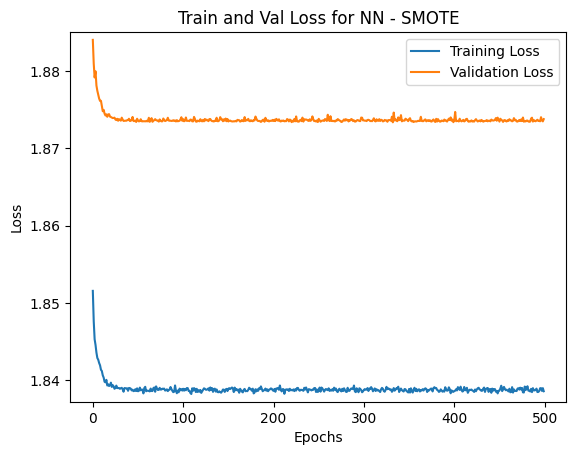

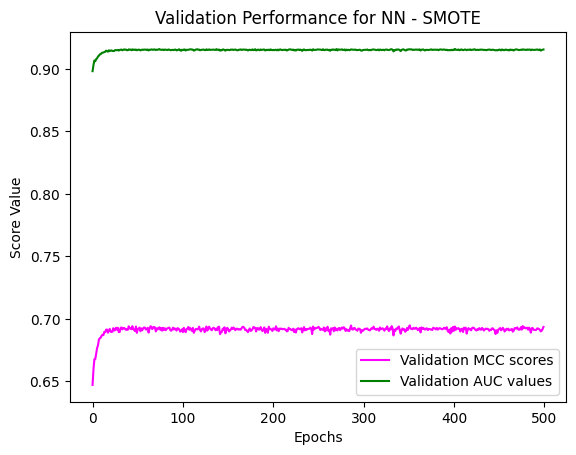

In [ ]:
best_model_filename_smt = "best_SMOTE.pt"
training_time = train_model_nn(X_train_smt, y_train_smt, X_val_smt, y_val_smt,
                               strategy= "SMOTE", best_model_filename= best_model_filename_smt)
training_times.append(training_time)

In [ ]:
training_time

3471.7629947662354

Test results for Neural Networks on the {} sample
Test Accuracy: 0.81936
Test Precision: 0.3537234042553192
Test Recall: 0.772133526850508
Test F1-score: 0.4851801185590515
Test ROC AUC: 0.8742741148507553
Test MCC: 0.437646414960706


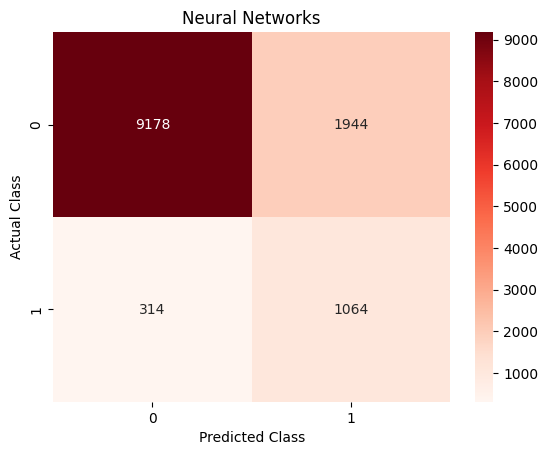

In [ ]:
best_model_filename_smt = "best_SMOTE.pt"
test_model_nn(X_test_norm, y_test_nn, best_model_filename_smt, "SMOTE")

### Consolidate results

In [ ]:
dict_nn = {"strategy": strategies, "model": models, "accuracy": accuracies,
           "precision": precisions, "recall": recalls, "f1_score": f1_scores,
           "mcc_score": mcc_scores, "roc_score": roc_scores, "training_time": training_times,
           "model_params": model_params, "cv_scores": cv_scores}

nn_results = pd.DataFrame.from_dict(dict_nn)
all_results = pd.concat([results, nn_results])
all_results

,strategy,model,accuracy,precision,recall,f1_score,mcc_score,roc_score,training_time,model_params,cv_scores
0,Base,LogisticRegression,0.906267,0.651961,0.321644,0.430769,0.414809,0.650182,1094.008490,"{'cf__C': 10, 'cf__penalty': 'l1', 'cf__solver...",[0.41832253 0.42707889 0.44205627 0.42984699 0...
1,Base,RandomForestClassifier,0.907800,0.720325,0.267836,0.390480,0.402719,0.627474,3600.330006,"{'cf__max_depth': None, 'cf__n_estimators': 75}",[0.39232531 0.40321367 0.41429885 0.40968577 0...
2,Base,XGBClassifier,0.913333,0.700680,0.373640,0.487382,0.471142,0.676929,1984.737359,"{'cf__eta': 0.2, 'cf__gamma': 0.0, 'cf__max_de...",[0.47364072 0.46298461 0.4848551 0.47490325 0...
3,SMOTE,LogisticRegression,0.811667,0.343072,0.773881,0.475395,0.427671,0.795115,974.110741,"{'cf__C': 0.1, 'cf__penalty': 'l1', 'cf__solve...",[0.42588286 0.43416801 0.4204781 0.42750929 0...
4,SMOTE,RandomForestClassifier,0.879733,0.464986,0.602177,0.524763,0.462228,0.758154,5434.984471,"{'cf__max_depth': 13, 'cf__n_estimators': 75}",[0.47215543 0.45937085 0.45842488 0.44852038 0...
5,SMOTE,XGBClassifier,0.905467,0.584770,0.492140,0.534471,0.484518,0.724416,3706.837207,"{'cf__eta': 0.2, 'cf__gamma': 0.2, 'cf__max_de...",[0.48480965 0.50460123 0.47827477 0.48149215 0...
6,Cost,LogisticRegression,0.803733,0.334869,0.790810,0.470504,0.425486,0.798073,1625.598365,"{'cf__C': 1, 'cf__penalty': 'l1', 'cf__solver'...",[0.42165791 0.42112043 0.42433957 0.42832447 0...
7,Cost,RandomForestClassifier,0.876867,0.456746,0.616082,0.524582,0.462377,0.762634,2654.962461,"{'cf__max_depth': 13, 'cf__n_estimators': 100}",[0.45641208 0.47465903 0.46296407 0.45225948 0...
8,Cost,XGBClassifier,0.913333,0.700680,0.373640,0.487382,0.471142,0.676929,2013.274483,"{'cf__eta': 0.2, 'cf__gamma': 0.0, 'cf__max_de...",[0.47364072 0.46298461 0.4848551 0.47490325 0...
0,Baseline,NeuralNetwork,0.867440,0.435086,0.678520,0.530196,0.472605,0.878527,1207.720386,Omitted,Not Applicable


In [ ]:
all_results.to_csv(PATH + 'Code/results/ALL_results.csv', index=False)